<a href="https://colab.research.google.com/github/rrl7012005/Reinforcement-Learning/blob/main/CartPole_with_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Actor critic method represent the policy function independent of the value function. The policy function returns a probability distribution over actions that an agent can take based on the given state. The value function determines the expected return for an agent starting at a given state and following a policy thereafter.

In actor-critic, the policy function is the actor proposing a set of actions given a state, and the critic is the estimated value function, evaluating actions taken by the actor based on the given policy.

In the CartPole environment, a pole is attached to a cart moving along a frictionless track, the pole is initially upright initially and the goal of the agent is to prevent it falling over by applying a force of -1 or +1 to the cart. +1 reward every time step the pole remains upright. The episode ends when the cart moves more than 2.4 units from the center or the pole is more than 15 degrees from the vertical.

The problem is solved when the average total reward for the episode reaches 195 over 100 consecutive trials.

#Initialization

In [ ]:
!pip install gym[classic_control]
!pip install pyglet

#for visualization

!sudo apt-get install -y pthon-opengl > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 kB 10.0 MB/s eta 0:00:00


In [ ]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

#Make the environment

env = gym.make('CartPole-v1')
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We will use Deep Reinforcement Learning. One neural net will generate the action probabilities and critic value respectively.

During the forward pass the model will take the state as the input and will output the action probs and the critic value V, which models the state dependent value function. The goal is to train a model that chooses actions based on a policy (the NN weights and biases) that maximizes expected return.

There are 4 dimensions to the state: the cart position, velocity, pole angle and pole velocity.

In [ ]:
class ActorCritic(tf.keras.Model):

  def __init__(self, num_actions: int, num_hidden_units: int):
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation='relu')
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Only one hidden layer whose hidden units process both the policy function and the value function

In [ ]:
num_actions = env.action_space.n #2 (left, right)
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

#Training

We need to run the agent on the environment to collect training data per episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the probabilities which will be applied to the environment etc.

We need to keep this in tensorflow operations so we use graphs.

In [ ]:
@tf.numpy_function(Tout=[tf.float32, tf.int32, tf.int32])
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

  state, reward, done, truncated = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))

In [ ]:
def run_episode(initial_state: tf.Tensor, model: tf.keras.Model, max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    state = tf.expand_dims(state, 0) #batch it
    action_logits_t, value = model(state)

    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    values = values.write(t, tf.squeeze(value))

    action_probs = action_probs.write(t, action_probs_t[0, action])

    state, reward, done = env_step(action)
    state.set_shape(initial_state_shape)

    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

The sequence of rewards for each timestep t, collected during one episode is converted into a sequence of expected returns in which the sumof rewards is taken from the current timestep t to T(the last) and the reward is multiplied with an exponentially decaying discount factor gamma so rewards further out are given less weight.

Expected return simply implies rewards now are better than rewards later, also mathematically its to ensure the sum of rewards converges.

To stabilize training, the resulting sequence of returns is also standardized.

$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$


In [ ]:
def get_expected_return(rewards: tf.Tensor, gamma: float, standardize: bool=True) -> tf.Tensor:

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  rewards = tf.cast(rewards[::-1], dtype=tf.float32) #start from the end and accumulate rewards
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape

  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)

  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))

  return returns

We are using a hybrid actor critic model, so the chosen loss function is a combination of Actor and Critic losses for training.

L = L_actor + L_critic

The actor loss is based on policy gradients with the critic as a state dependent baseline and computed with single sample per episode estimates.

$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$

T: the number of timesteps per episode  
s_t: the state at timestep t  
a_t: chosen action at timestep t given state s  
pi_theta: the policy parameterized by theta  
V: value function parameterized by theta  
G = G_t: the expected return for a given state, action pair at timestep 5

A negative term is added to the sum since the idea is to maximize probabilities of actions yielding higher rewards by minimizing the combined loss.

The G-V term in the L_actor term is called the Advantage which indicates how much better an action is given a particular state over a random action selected according to the policy pi for that state. We could exclude the baseline, but this will cause high variance during training, also choosing the critic V as a baseline so it is trained to be as close as possible to G, leading to a lower variance.

Without the critic, the algorithm may try to increase probabilities for actions taken on a particular state based on expected return which may not make much of a difference if the relative probabilities between actions remain the same. For instance suppose 2 actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective J. With the critic, it may turn out that there is no advantage (G-V=0) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.


The critic loss is training V to be as close as possible G, it can set up as a regression problem with the huber loss function.

$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$

In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(action_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor) -> tf.Tensor:

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

Define a training step, we use tf.GradientTape to enable automatic differentiation.

episode_reward is the sum of the undiscounted rewards.  


In [ ]:
@tf.function
def train_step(initial_state: tf.Tensor, model: tf.keras.Model,
               optimizer: tf.keras.optimizers.Optimizer,
               gamma: float, max_steps_per_episode: int) -> tf.Tensor:

  with tf.GradientTape() as tape:

    action_probs, values, rewards = run_episode(initial_state, model,
                                                max_steps_per_episode)

    returns = get_expected_return(rewards, gamma)

    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    loss = compute_loss(action_probs, values, returns)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward


Training is executed until the success criterion or maximum number of episodes is reached.

A record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left end of the queue and the newest one is added at the head.

In [ ]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

reward_threshold = 475
running_reward = 0

gamma = 0.99

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
  initial_state = env.reset()
  initial_state = tf.constant(initial_state, dtype=tf.float32)
  episode_reward = int(train_step(
      initial_state, model, optimizer, gamma, max_steps_per_episode))

  episodes_reward.append(episode_reward)
  running_reward = statistics.mean(episodes_reward)

  t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

  if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')

  if running_reward > reward_threshold and i >= min_episodes_criterion:
      break

  print(f'Solved at episode {i}: average reward: {running_reward:.2f}!')


  0%|          | 8/10000 [00:02<38:11,  4.36it/s, episode_reward=24, running_reward=20.2]

Solved at episode 0: average reward: 32.00!
Solved at episode 1: average reward: 33.00!
Solved at episode 2: average reward: 26.67!
Solved at episode 3: average reward: 22.25!
Solved at episode 4: average reward: 21.20!
Solved at episode 5: average reward: 19.33!
Solved at episode 6: average reward: 19.71!
Solved at episode 7: average reward: 19.62!
Solved at episode 8: average reward: 21.56!
Solved at episode 9: average reward: 20.80!
Solved at episode 10: average reward: 21.36!
Solved at episode 11: average reward: 20.42!
Solved at episode 12: average reward: 19.92!
Solved at episode 13: average reward: 20.21!


  0%|          | 21/10000 [00:02<11:54, 13.96it/s, episode_reward=14, running_reward=20.4]

Solved at episode 14: average reward: 21.47!
Solved at episode 15: average reward: 21.00!
Solved at episode 16: average reward: 21.88!
Solved at episode 17: average reward: 22.22!
Solved at episode 18: average reward: 21.89!
Solved at episode 19: average reward: 21.80!
Solved at episode 20: average reward: 21.95!
Solved at episode 21: average reward: 21.68!
Solved at episode 22: average reward: 21.48!
Solved at episode 23: average reward: 21.12!
Solved at episode 24: average reward: 20.96!
Solved at episode 25: average reward: 20.62!
Solved at episode 26: average reward: 20.37!


  0%|          | 35/10000 [00:02<06:10, 26.91it/s, episode_reward=45, running_reward=24.5] 

Solved at episode 27: average reward: 21.00!
Solved at episode 28: average reward: 20.69!
Solved at episode 29: average reward: 20.33!
Solved at episode 30: average reward: 20.68!
Solved at episode 31: average reward: 21.72!
Solved at episode 32: average reward: 21.85!
Solved at episode 33: average reward: 21.56!
Solved at episode 34: average reward: 21.69!
Solved at episode 35: average reward: 23.89!
Solved at episode 36: average reward: 24.46!


  0%|          | 41/10000 [00:03<05:49, 28.51it/s, episode_reward=133, running_reward=29.2]

Solved at episode 37: average reward: 24.89!
Solved at episode 38: average reward: 26.82!
Solved at episode 39: average reward: 26.55!
Solved at episode 40: average reward: 26.20!
Solved at episode 41: average reward: 26.69!
Solved at episode 42: average reward: 29.16!


  0%|          | 47/10000 [00:03<06:09, 26.91it/s, episode_reward=36, running_reward=31.2]

Solved at episode 43: average reward: 29.23!
Solved at episode 44: average reward: 31.22!
Solved at episode 45: average reward: 30.91!
Solved at episode 46: average reward: 31.53!
Solved at episode 47: average reward: 31.23!
Solved at episode 48: average reward: 31.12!
Solved at episode 49: average reward: 31.22!


  1%|          | 57/10000 [00:03<05:20, 31.01it/s, episode_reward=40, running_reward=33.5]

Solved at episode 50: average reward: 32.67!
Solved at episode 51: average reward: 33.06!
Solved at episode 52: average reward: 32.85!
Solved at episode 53: average reward: 32.74!
Solved at episode 54: average reward: 32.85!
Solved at episode 55: average reward: 33.30!
Solved at episode 56: average reward: 33.32!
Solved at episode 57: average reward: 33.36!
Solved at episode 58: average reward: 33.47!


  1%|          | 62/10000 [00:03<05:46, 28.71it/s, episode_reward=79, running_reward=35.7]

Solved at episode 59: average reward: 33.58!
Solved at episode 60: average reward: 34.16!
Solved at episode 61: average reward: 35.16!
Solved at episode 62: average reward: 35.03!
Solved at episode 63: average reward: 35.72!


  1%|          | 66/10000 [00:04<07:06, 23.27it/s, episode_reward=176, running_reward=39.4]

Solved at episode 64: average reward: 37.31!
Solved at episode 65: average reward: 39.41!


  1%|          | 69/10000 [00:04<08:44, 18.95it/s, episode_reward=47, running_reward=44.9]

Solved at episode 66: average reward: 43.72!
Solved at episode 67: average reward: 43.91!
Solved at episode 68: average reward: 44.10!
Solved at episode 69: average reward: 44.09!
Solved at episode 70: average reward: 44.83!


  1%|          | 76/10000 [00:04<07:23, 22.37it/s, episode_reward=21, running_reward=44.6]

Solved at episode 71: average reward: 44.86!
Solved at episode 72: average reward: 45.16!
Solved at episode 73: average reward: 44.92!
Solved at episode 74: average reward: 44.75!
Solved at episode 75: average reward: 44.89!
Solved at episode 76: average reward: 44.58!


  1%|          | 84/10000 [00:04<06:03, 27.28it/s, episode_reward=42, running_reward=44.6]

Solved at episode 77: average reward: 45.62!
Solved at episode 78: average reward: 45.32!
Solved at episode 79: average reward: 45.21!
Solved at episode 80: average reward: 44.96!
Solved at episode 81: average reward: 44.71!
Solved at episode 82: average reward: 44.47!
Solved at episode 83: average reward: 44.62!
Solved at episode 84: average reward: 44.60!


  1%|          | 87/10000 [00:05<07:02, 23.46it/s, episode_reward=251, running_reward=46.9]

Solved at episode 85: average reward: 44.57!
Solved at episode 86: average reward: 46.94!


  1%|          | 90/10000 [00:05<07:44, 21.32it/s, episode_reward=36, running_reward=48.4] 

Solved at episode 87: average reward: 47.50!
Solved at episode 88: average reward: 47.52!
Solved at episode 89: average reward: 47.56!
Solved at episode 90: average reward: 48.51!
Solved at episode 91: average reward: 48.37!


  1%|          | 96/10000 [00:05<08:59, 18.37it/s, episode_reward=22, running_reward=50.9]

Solved at episode 92: average reward: 49.89!
Solved at episode 93: average reward: 50.52!
Solved at episode 94: average reward: 51.22!
Solved at episode 95: average reward: 50.92!


  1%|          | 99/10000 [00:05<08:39, 19.06it/s, episode_reward=45, running_reward=51.4]

Solved at episode 96: average reward: 51.08!
Solved at episode 97: average reward: 51.42!
Solved at episode 98: average reward: 51.38!
Solved at episode 99: average reward: 51.13!
Solved at episode 100: average reward: 51.14!
Solved at episode 101: average reward: 51.13!
Solved at episode 102: average reward: 51.44!


  1%|          | 107/10000 [00:06<06:45, 24.39it/s, episode_reward=99, running_reward=53.8]

Solved at episode 103: average reward: 51.78!
Solved at episode 104: average reward: 52.42!
Solved at episode 105: average reward: 52.72!
Solved at episode 106: average reward: 53.02!
Solved at episode 107: average reward: 53.82!


  1%|          | 113/10000 [00:06<07:05, 23.22it/s, episode_reward=116, running_reward=55]

Solved at episode 108: average reward: 53.66!
Solved at episode 109: average reward: 53.81!
Solved at episode 110: average reward: 53.89!
Solved at episode 111: average reward: 54.01!
Solved at episode 112: average reward: 55.03!


  1%|          | 116/10000 [00:06<08:31, 19.31it/s, episode_reward=54, running_reward=57.7]

Solved at episode 113: average reward: 55.99!
Solved at episode 114: average reward: 56.80!
Solved at episode 115: average reward: 57.52!
Solved at episode 116: average reward: 57.70!


  1%|          | 122/10000 [00:06<07:52, 20.92it/s, episode_reward=82, running_reward=59.6]

Solved at episode 117: average reward: 57.87!
Solved at episode 118: average reward: 58.07!
Solved at episode 119: average reward: 58.38!
Solved at episode 120: average reward: 58.96!
Solved at episode 121: average reward: 59.62!


  1%|▏         | 125/10000 [00:06<09:20, 17.61it/s, episode_reward=143, running_reward=62.9]

Solved at episode 122: average reward: 60.45!
Solved at episode 123: average reward: 61.65!
Solved at episode 124: average reward: 62.91!


  1%|▏         | 129/10000 [00:07<09:57, 16.52it/s, episode_reward=100, running_reward=65.8]

Solved at episode 125: average reward: 63.62!
Solved at episode 126: average reward: 64.33!
Solved at episode 127: average reward: 64.93!
Solved at episode 128: average reward: 65.81!


  1%|▏         | 131/10000 [00:07<11:43, 14.03it/s, episode_reward=127, running_reward=69]  

Solved at episode 129: average reward: 66.94!
Solved at episode 130: average reward: 68.28!
Solved at episode 131: average reward: 69.01!


  1%|▏         | 135/10000 [00:07<12:16, 13.39it/s, episode_reward=176, running_reward=73.1]

Solved at episode 132: average reward: 70.27!
Solved at episode 133: average reward: 71.57!
Solved at episode 134: average reward: 73.07!


  1%|▏         | 137/10000 [00:07<12:17, 13.37it/s, episode_reward=124, running_reward=75.7]

Solved at episode 135: average reward: 73.94!
Solved at episode 136: average reward: 74.85!
Solved at episode 137: average reward: 75.68!


  1%|▏         | 141/10000 [00:08<13:45, 11.94it/s, episode_reward=230, running_reward=80.8]

Solved at episode 138: average reward: 76.79!
Solved at episode 139: average reward: 78.58!
Solved at episode 140: average reward: 80.76!


  1%|▏         | 141/10000 [00:08<13:45, 11.94it/s, episode_reward=201, running_reward=82.3]

Solved at episode 141: average reward: 82.30!


  1%|▏         | 143/10000 [00:08<17:13,  9.54it/s, episode_reward=274, running_reward=88.4]

Solved at episode 142: average reward: 85.97!
Solved at episode 143: average reward: 88.39!


  1%|▏         | 146/10000 [00:09<20:06,  8.16it/s, episode_reward=231, running_reward=94.3]

Solved at episode 144: average reward: 92.20!
Solved at episode 145: average reward: 94.34!


  1%|▏         | 149/10000 [00:09<17:07,  9.59it/s, episode_reward=153, running_reward=100] 

Solved at episode 146: average reward: 96.56!
Solved at episode 147: average reward: 97.61!
Solved at episode 148: average reward: 98.86!
Solved at episode 149: average reward: 100.03!


  2%|▏         | 153/10000 [00:09<15:16, 10.74it/s, episode_reward=227, running_reward=104]

Solved at episode 150: average reward: 100.77!
Solved at episode 151: average reward: 101.81!
Solved at episode 152: average reward: 103.86!


  2%|▏         | 153/10000 [00:09<15:16, 10.74it/s, episode_reward=486, running_reward=108]

Solved at episode 153: average reward: 108.45!


  2%|▏         | 157/10000 [00:10<19:51,  8.26it/s, episode_reward=239, running_reward=116]

Solved at episode 154: average reward: 113.06!
Solved at episode 155: average reward: 113.83!
Solved at episode 156: average reward: 115.88!


  2%|▏         | 160/10000 [00:10<19:39,  8.34it/s, episode_reward=224, running_reward=123]

Solved at episode 157: average reward: 120.52!
Solved at episode 158: average reward: 121.58!
Solved at episode 159: average reward: 123.42!


  2%|▏         | 160/10000 [00:10<19:39,  8.34it/s, episode_reward=87, running_reward=124] 

Solved at episode 160: average reward: 123.60!


  2%|▏         | 162/10000 [00:10<20:21,  8.06it/s, episode_reward=91, running_reward=128] 

Solved at episode 161: average reward: 127.60!
Solved at episode 162: average reward: 128.24!


  2%|▏         | 165/10000 [00:11<22:21,  7.33it/s, episode_reward=455, running_reward=135]

Solved at episode 163: average reward: 131.46!
Solved at episode 164: average reward: 134.62!


  2%|▏         | 166/10000 [00:11<25:13,  6.50it/s, episode_reward=182, running_reward=136]

Solved at episode 165: average reward: 137.86!
Solved at episode 166: average reward: 136.40!


  2%|▏         | 169/10000 [00:12<24:57,  6.57it/s, episode_reward=338, running_reward=144]

Solved at episode 167: average reward: 140.83!
Solved at episode 168: average reward: 143.64!


  2%|▏         | 172/10000 [00:12<19:29,  8.40it/s, episode_reward=36, running_reward=147]

Solved at episode 169: average reward: 144.65!
Solved at episode 170: average reward: 143.91!
Solved at episode 171: average reward: 146.96!
Solved at episode 172: average reward: 146.50!


  2%|▏         | 178/10000 [00:12<11:43, 13.97it/s, episode_reward=82, running_reward=149] 

Solved at episode 173: average reward: 146.59!
Solved at episode 174: average reward: 146.55!
Solved at episode 175: average reward: 146.87!
Solved at episode 176: average reward: 148.03!
Solved at episode 177: average reward: 148.07!


  2%|▏         | 181/10000 [00:12<10:14, 15.97it/s, episode_reward=78, running_reward=151] 

Solved at episode 178: average reward: 148.67!
Solved at episode 179: average reward: 148.90!
Solved at episode 180: average reward: 149.88!
Solved at episode 181: average reward: 150.65!
Solved at episode 182: average reward: 151.18!


  2%|▏         | 187/10000 [00:12<08:42, 18.78it/s, episode_reward=29, running_reward=150]

Solved at episode 183: average reward: 151.73!
Solved at episode 184: average reward: 152.10!
Solved at episode 185: average reward: 152.44!
Solved at episode 186: average reward: 150.61!
Solved at episode 187: average reward: 149.94!


  2%|▏         | 190/10000 [00:13<08:34, 19.06it/s, episode_reward=233, running_reward=153]

Solved at episode 188: average reward: 150.61!
Solved at episode 189: average reward: 151.75!
Solved at episode 190: average reward: 152.74!


  2%|▏         | 195/10000 [00:13<09:05, 17.96it/s, episode_reward=93, running_reward=152]

Solved at episode 191: average reward: 152.94!
Solved at episode 192: average reward: 151.76!
Solved at episode 193: average reward: 151.85!
Solved at episode 194: average reward: 151.61!


  2%|▏         | 199/10000 [00:13<10:13, 15.98it/s, episode_reward=97, running_reward=156]

Solved at episode 195: average reward: 153.60!
Solved at episode 196: average reward: 154.62!
Solved at episode 197: average reward: 155.20!
Solved at episode 198: average reward: 155.69!


  2%|▏         | 201/10000 [00:13<10:30, 15.54it/s, episode_reward=107, running_reward=160]

Solved at episode 199: average reward: 156.61!
Solved at episode 200: average reward: 158.00!
Solved at episode 201: average reward: 159.03!


  2%|▏         | 206/10000 [00:14<09:44, 16.76it/s, episode_reward=76, running_reward=161] 

Solved at episode 202: average reward: 159.65!
Solved at episode 203: average reward: 160.17!
Solved at episode 204: average reward: 160.26!
Solved at episode 205: average reward: 161.12!
Solved at episode 206: average reward: 161.36!


  2%|▏         | 212/10000 [00:14<07:59, 20.43it/s, episode_reward=72, running_reward=163]

Solved at episode 207: average reward: 161.08!
Solved at episode 208: average reward: 161.68!
Solved at episode 209: average reward: 162.18!
Solved at episode 210: average reward: 162.44!
Solved at episode 211: average reward: 162.94!


  2%|▏         | 215/10000 [00:14<08:31, 19.14it/s, episode_reward=68, running_reward=163] 

Solved at episode 212: average reward: 163.16!
Solved at episode 213: average reward: 162.67!
Solved at episode 214: average reward: 162.97!
Solved at episode 215: average reward: 163.29!
Solved at episode 216: average reward: 163.43!


  2%|▏         | 221/10000 [00:14<08:35, 18.96it/s, episode_reward=49, running_reward=166] 

Solved at episode 217: average reward: 164.67!
Solved at episode 218: average reward: 165.10!
Solved at episode 219: average reward: 165.36!
Solved at episode 220: average reward: 165.90!
Solved at episode 221: average reward: 165.57!


  2%|▏         | 224/10000 [00:14<08:10, 19.92it/s, episode_reward=121, running_reward=165]

Solved at episode 222: average reward: 165.22!
Solved at episode 223: average reward: 165.10!


  2%|▏         | 227/10000 [00:15<09:57, 16.36it/s, episode_reward=133, running_reward=168]

Solved at episode 224: average reward: 167.05!
Solved at episode 225: average reward: 167.31!
Solved at episode 226: average reward: 167.17!
Solved at episode 227: average reward: 167.52!


  2%|▏         | 231/10000 [00:15<10:04, 16.16it/s, episode_reward=99, running_reward=168]

Solved at episode 228: average reward: 168.27!
Solved at episode 229: average reward: 168.35!
Solved at episode 230: average reward: 167.69!


  2%|▏         | 233/10000 [00:15<11:28, 14.19it/s, episode_reward=105, running_reward=169]

Solved at episode 231: average reward: 169.09!
Solved at episode 232: average reward: 169.17!
Solved at episode 233: average reward: 168.80!


  2%|▏         | 235/10000 [00:15<12:00, 13.54it/s, episode_reward=180, running_reward=169]

Solved at episode 234: average reward: 169.54!
Solved at episode 235: average reward: 169.46!


  2%|▏         | 239/10000 [00:16<14:56, 10.89it/s, episode_reward=211, running_reward=172]

Solved at episode 236: average reward: 171.99!
Solved at episode 237: average reward: 172.35!
Solved at episode 238: average reward: 172.35!


  2%|▏         | 241/10000 [00:16<18:07,  8.97it/s, episode_reward=342, running_reward=176]

Solved at episode 239: average reward: 174.48!
Solved at episode 240: average reward: 175.60!


  2%|▏         | 243/10000 [00:16<19:06,  8.51it/s, episode_reward=102, running_reward=173]

Solved at episode 241: average reward: 178.59!
Solved at episode 242: average reward: 174.54!
Solved at episode 243: average reward: 172.82!


  2%|▏         | 246/10000 [00:17<20:53,  7.78it/s, episode_reward=409, running_reward=174]

Solved at episode 244: average reward: 171.72!
Solved at episode 245: average reward: 173.50!


  2%|▏         | 247/10000 [00:17<23:48,  6.83it/s, episode_reward=474, running_reward=175]

Solved at episode 246: average reward: 175.42!


  2%|▏         | 248/10000 [00:17<27:55,  5.82it/s, episode_reward=86, running_reward=178] 

Solved at episode 247: average reward: 178.46!
Solved at episode 248: average reward: 177.81!


  2%|▎         | 250/10000 [00:18<27:18,  5.95it/s, episode_reward=449, running_reward=181]

Solved at episode 249: average reward: 180.77!


  3%|▎         | 251/10000 [00:18<31:12,  5.21it/s, episode_reward=500, running_reward=184]

Solved at episode 250: average reward: 183.98!


  3%|▎         | 252/10000 [00:18<34:35,  4.70it/s, episode_reward=500, running_reward=187]

Solved at episode 251: average reward: 187.41!


  3%|▎         | 253/10000 [00:18<37:07,  4.38it/s, episode_reward=500, running_reward=190]

Solved at episode 252: average reward: 190.14!


  3%|▎         | 254/10000 [00:19<39:34,  4.10it/s, episode_reward=500, running_reward=190]

Solved at episode 253: average reward: 190.28!


  3%|▎         | 255/10000 [00:19<40:08,  4.05it/s, episode_reward=500, running_reward=190]

Solved at episode 254: average reward: 190.28!


  3%|▎         | 256/10000 [00:19<42:26,  3.83it/s, episode_reward=500, running_reward=194]

Solved at episode 255: average reward: 193.93!


  3%|▎         | 257/10000 [00:20<45:28,  3.57it/s, episode_reward=500, running_reward=197]

Solved at episode 256: average reward: 196.54!


  3%|▎         | 258/10000 [00:20<47:42,  3.40it/s, episode_reward=500, running_reward=197]

Solved at episode 257: average reward: 196.54!


  3%|▎         | 259/10000 [00:20<48:03,  3.38it/s, episode_reward=500, running_reward=200]

Solved at episode 258: average reward: 200.08!


  3%|▎         | 260/10000 [00:21<48:19,  3.36it/s, episode_reward=500, running_reward=203]

Solved at episode 259: average reward: 202.84!


  3%|▎         | 261/10000 [00:21<50:43,  3.20it/s, episode_reward=500, running_reward=207]

Solved at episode 260: average reward: 206.97!


  3%|▎         | 262/10000 [00:21<47:40,  3.40it/s, episode_reward=500, running_reward=207]

Solved at episode 261: average reward: 207.01!


  3%|▎         | 263/10000 [00:21<43:52,  3.70it/s, episode_reward=500, running_reward=211]

Solved at episode 262: average reward: 211.10!


  3%|▎         | 264/10000 [00:22<41:47,  3.88it/s, episode_reward=500, running_reward=212]

Solved at episode 263: average reward: 212.09!


  3%|▎         | 265/10000 [00:22<40:11,  4.04it/s, episode_reward=500, running_reward=213]

Solved at episode 264: average reward: 212.54!


  3%|▎         | 266/10000 [00:22<38:41,  4.19it/s, episode_reward=500, running_reward=213]

Solved at episode 265: average reward: 212.54!


  3%|▎         | 267/10000 [00:22<37:32,  4.32it/s, episode_reward=500, running_reward=216]

Solved at episode 266: average reward: 215.72!


  3%|▎         | 268/10000 [00:22<36:15,  4.47it/s, episode_reward=500, running_reward=216]

Solved at episode 267: average reward: 215.72!


  3%|▎         | 269/10000 [00:23<36:40,  4.42it/s, episode_reward=500, running_reward=217]

Solved at episode 268: average reward: 217.34!


  3%|▎         | 270/10000 [00:23<36:26,  4.45it/s, episode_reward=500, running_reward=221]

Solved at episode 269: average reward: 220.90!


  3%|▎         | 271/10000 [00:23<36:05,  4.49it/s, episode_reward=500, running_reward=226]

Solved at episode 270: average reward: 225.67!


  3%|▎         | 272/10000 [00:23<35:39,  4.55it/s, episode_reward=500, running_reward=227]

Solved at episode 271: average reward: 227.15!


  3%|▎         | 273/10000 [00:24<35:31,  4.56it/s, episode_reward=500, running_reward=232]

Solved at episode 272: average reward: 231.94!


  3%|▎         | 274/10000 [00:24<35:43,  4.54it/s, episode_reward=500, running_reward=237]

Solved at episode 273: average reward: 236.58!


  3%|▎         | 275/10000 [00:24<36:01,  4.50it/s, episode_reward=500, running_reward=241]

Solved at episode 274: average reward: 241.30!


  3%|▎         | 276/10000 [00:24<35:51,  4.52it/s, episode_reward=500, running_reward=245]

Solved at episode 275: average reward: 245.42!


  3%|▎         | 277/10000 [00:24<35:40,  4.54it/s, episode_reward=500, running_reward=249]

Solved at episode 276: average reward: 249.05!


  3%|▎         | 278/10000 [00:25<36:10,  4.48it/s, episode_reward=500, running_reward=253]

Solved at episode 277: average reward: 252.76!


  3%|▎         | 279/10000 [00:25<36:58,  4.38it/s, episode_reward=500, running_reward=257]

Solved at episode 278: average reward: 256.94!


  3%|▎         | 280/10000 [00:25<36:14,  4.47it/s, episode_reward=500, running_reward=261]

Solved at episode 279: average reward: 261.34!


  3%|▎         | 281/10000 [00:25<35:40,  4.54it/s, episode_reward=500, running_reward=265]

Solved at episode 280: average reward: 265.11!


  3%|▎         | 282/10000 [00:26<35:05,  4.61it/s, episode_reward=500, running_reward=269]

Solved at episode 281: average reward: 269.10!


  3%|▎         | 283/10000 [00:26<35:50,  4.52it/s, episode_reward=500, running_reward=273]

Solved at episode 282: average reward: 273.32!


  3%|▎         | 284/10000 [00:26<35:57,  4.50it/s, episode_reward=500, running_reward=277]

Solved at episode 283: average reward: 277.20!


  3%|▎         | 285/10000 [00:26<36:06,  4.48it/s, episode_reward=500, running_reward=281]

Solved at episode 284: average reward: 281.40!


  3%|▎         | 286/10000 [00:26<35:44,  4.53it/s, episode_reward=500, running_reward=286]

Solved at episode 285: average reward: 285.64!


  3%|▎         | 287/10000 [00:27<36:31,  4.43it/s, episode_reward=500, running_reward=290]

Solved at episode 286: average reward: 289.96!


  3%|▎         | 288/10000 [00:27<36:11,  4.47it/s, episode_reward=500, running_reward=295]

Solved at episode 287: average reward: 294.67!


  3%|▎         | 289/10000 [00:27<35:55,  4.51it/s, episode_reward=500, running_reward=299]

Solved at episode 288: average reward: 298.51!


  3%|▎         | 290/10000 [00:27<35:45,  4.53it/s, episode_reward=500, running_reward=302]

Solved at episode 289: average reward: 301.86!


  3%|▎         | 291/10000 [00:28<35:33,  4.55it/s, episode_reward=500, running_reward=305]

Solved at episode 290: average reward: 304.53!


  3%|▎         | 292/10000 [00:28<35:56,  4.50it/s, episode_reward=500, running_reward=309]

Solved at episode 291: average reward: 308.97!


  3%|▎         | 293/10000 [00:28<36:03,  4.49it/s, episode_reward=500, running_reward=313]

Solved at episode 292: average reward: 313.25!


  3%|▎         | 294/10000 [00:28<36:14,  4.46it/s, episode_reward=500, running_reward=317]

Solved at episode 293: average reward: 317.07!


  3%|▎         | 295/10000 [00:28<35:56,  4.50it/s, episode_reward=500, running_reward=321]

Solved at episode 294: average reward: 321.14!


  3%|▎         | 296/10000 [00:29<36:10,  4.47it/s, episode_reward=500, running_reward=324]

Solved at episode 295: average reward: 323.93!


  3%|▎         | 297/10000 [00:29<35:25,  4.56it/s, episode_reward=500, running_reward=327]

Solved at episode 296: average reward: 327.24!


  3%|▎         | 298/10000 [00:29<35:58,  4.50it/s, episode_reward=500, running_reward=331]

Solved at episode 297: average reward: 330.82!


  3%|▎         | 299/10000 [00:29<35:56,  4.50it/s, episode_reward=500, running_reward=335]

Solved at episode 298: average reward: 334.85!


  3%|▎         | 300/10000 [00:30<35:20,  4.58it/s, episode_reward=500, running_reward=339]

Solved at episode 299: average reward: 338.67!


  3%|▎         | 301/10000 [00:30<36:08,  4.47it/s, episode_reward=500, running_reward=342]

Solved at episode 300: average reward: 341.95!


  3%|▎         | 302/10000 [00:30<35:56,  4.50it/s, episode_reward=500, running_reward=346]

Solved at episode 301: average reward: 345.59!


  3%|▎         | 303/10000 [00:30<36:04,  4.48it/s, episode_reward=500, running_reward=350]

Solved at episode 302: average reward: 349.52!


  3%|▎         | 304/10000 [00:30<35:36,  4.54it/s, episode_reward=500, running_reward=354]

Solved at episode 303: average reward: 353.57!


  3%|▎         | 305/10000 [00:31<36:07,  4.47it/s, episode_reward=500, running_reward=358]

Solved at episode 304: average reward: 357.67!


  3%|▎         | 306/10000 [00:31<35:36,  4.54it/s, episode_reward=500, running_reward=361]

Solved at episode 305: average reward: 361.41!


  3%|▎         | 307/10000 [00:31<37:35,  4.30it/s, episode_reward=500, running_reward=366]

Solved at episode 306: average reward: 365.65!


  3%|▎         | 308/10000 [00:31<40:59,  3.94it/s, episode_reward=500, running_reward=370]

Solved at episode 307: average reward: 369.94!


  3%|▎         | 309/10000 [00:32<43:12,  3.74it/s, episode_reward=500, running_reward=374]

Solved at episode 308: average reward: 374.13!


  3%|▎         | 310/10000 [00:32<43:13,  3.74it/s, episode_reward=500, running_reward=378]

Solved at episode 309: average reward: 378.34!


  3%|▎         | 311/10000 [00:32<44:14,  3.65it/s, episode_reward=500, running_reward=383]

Solved at episode 310: average reward: 382.73!


  3%|▎         | 312/10000 [00:33<43:49,  3.68it/s, episode_reward=500, running_reward=387]

Solved at episode 311: average reward: 387.01!


  3%|▎         | 313/10000 [00:33<44:09,  3.66it/s, episode_reward=500, running_reward=391]

Solved at episode 312: average reward: 390.63!


  3%|▎         | 314/10000 [00:33<47:18,  3.41it/s, episode_reward=500, running_reward=395]

Solved at episode 313: average reward: 394.92!


  3%|▎         | 315/10000 [00:33<46:54,  3.44it/s, episode_reward=500, running_reward=398]

Solved at episode 314: average reward: 398.42!


  3%|▎         | 316/10000 [00:34<48:16,  3.34it/s, episode_reward=500, running_reward=402]

Solved at episode 315: average reward: 402.24!


  3%|▎         | 317/10000 [00:34<48:47,  3.31it/s, episode_reward=500, running_reward=407]

Solved at episode 316: average reward: 406.56!


  3%|▎         | 318/10000 [00:34<49:35,  3.25it/s, episode_reward=500, running_reward=410]

Solved at episode 317: average reward: 409.87!


  3%|▎         | 319/10000 [00:35<51:35,  3.13it/s, episode_reward=500, running_reward=414]

Solved at episode 318: average reward: 414.08!


  3%|▎         | 320/10000 [00:35<48:45,  3.31it/s, episode_reward=500, running_reward=418]

Solved at episode 319: average reward: 418.31!


  3%|▎         | 321/10000 [00:35<44:57,  3.59it/s, episode_reward=500, running_reward=422]

Solved at episode 320: average reward: 421.94!


  3%|▎         | 322/10000 [00:35<42:11,  3.82it/s, episode_reward=500, running_reward=426]

Solved at episode 321: average reward: 426.45!


  3%|▎         | 323/10000 [00:36<40:27,  3.99it/s, episode_reward=500, running_reward=431]

Solved at episode 322: average reward: 430.80!


  3%|▎         | 324/10000 [00:36<38:30,  4.19it/s, episode_reward=500, running_reward=435]

Solved at episode 323: average reward: 434.59!


  3%|▎         | 325/10000 [00:36<37:17,  4.32it/s, episode_reward=500, running_reward=436]

Solved at episode 324: average reward: 436.21!


  3%|▎         | 326/10000 [00:36<37:10,  4.34it/s, episode_reward=500, running_reward=440]

Solved at episode 325: average reward: 440.12!


  3%|▎         | 327/10000 [00:37<36:47,  4.38it/s, episode_reward=500, running_reward=444]

Solved at episode 326: average reward: 444.41!


  3%|▎         | 328/10000 [00:37<36:08,  4.46it/s, episode_reward=500, running_reward=448]

Solved at episode 327: average reward: 448.08!


  3%|▎         | 329/10000 [00:37<35:58,  4.48it/s, episode_reward=500, running_reward=451]

Solved at episode 328: average reward: 451.33!


  3%|▎         | 330/10000 [00:37<36:01,  4.47it/s, episode_reward=500, running_reward=455]

Solved at episode 329: average reward: 455.02!


  3%|▎         | 331/10000 [00:37<36:36,  4.40it/s, episode_reward=500, running_reward=459]

Solved at episode 330: average reward: 459.03!


  3%|▎         | 332/10000 [00:38<36:09,  4.46it/s, episode_reward=500, running_reward=461]

Solved at episode 331: average reward: 461.36!


  3%|▎         | 333/10000 [00:38<36:00,  4.48it/s, episode_reward=500, running_reward=465]

Solved at episode 332: average reward: 464.76!


  3%|▎         | 334/10000 [00:38<35:22,  4.55it/s, episode_reward=500, running_reward=469]

Solved at episode 333: average reward: 468.71!


  3%|▎         | 335/10000 [00:38<35:40,  4.51it/s, episode_reward=500, running_reward=471]

Solved at episode 334: average reward: 471.21!


  3%|▎         | 336/10000 [00:39<36:13,  4.45it/s, episode_reward=500, running_reward=474]

Solved at episode 335: average reward: 474.41!


  3%|▎         | 336/10000 [00:39<18:51,  8.54it/s, episode_reward=500, running_reward=476]

CPU times: user 47.4 s, sys: 1.5 s, total: 48.9 s
Wall time: 39.3 s


Visualization of performance

In [ ]:
from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make('CartPole-v1', render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int):

  state = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  if isinstance(screen, list):
    screen = screen[0]

  images = [Image.fromarray(screen)]

  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    if i % 10 == 0:
      screen = env.render()
      if isinstance(screen, list):
          screen = screen[0]
      images.append(Image.fromarray(screen))
    if done:
      break

  return images

images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'cartpole-v1.gif'

images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



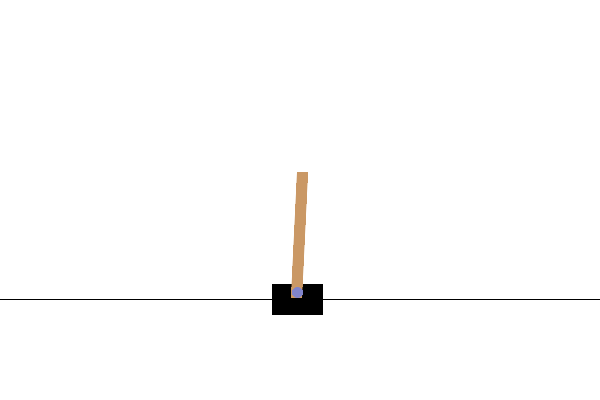

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)